In [156]:
import numpy as np 
from matplotlib import pyplot as plt
import math
import random

In [190]:
def rand_row(n, prop_b):
    return ((np.random.random(n) < prop_b) * 1).tolist()

def rand_rule(neighbors):
    n = pow(2, neighbors)
    return rand_row(n, .5)

def next_row(row, rule):
    neighbors = int(math.log2(len(rule)))
    rang = math.trunc(neighbors / 2)
    next_row = []
    for i in range(len(row)):
        definition = ""
        for n in range(neighbors):
            definition = definition + str(row[(i+n-rang) % (len(row))])
        # print(definition)
        next_row.append(rule[int(definition, 2)])

    return next_row

def row_iterations(row, rule, N, show = False):
    matrix = [row]
    new_row = row
    for i in range(N-1):
        new_row = next_row(new_row, rule)
        matrix.append(new_row)

    matrix = np.array(matrix).astype(np.float)

    if show:
        plt.imshow(matrix)
        plt.show()
    
    return matrix

def gen_map(dimension, perc_zero, rule, show = False):
    return row_iterations(rand_row(dimension,perc_zero), rule, dimension, show)

def prop_one(map):
    dim = map.shape[0]
    return region_sum(map) / (dim * dim)

def local_groups(map, value, size):
    dim = map.shape[0]
    for row in range(dim - size + 1):
        for col in range(dim - size + 1):
            locality = map[row:(row+size),col:(col+size)]
            ldim = locality.shape[0]
            tot = region_sum(locality)
            if value == 0 and tot == 0: return True
            if value == 1 and tot == ldim * ldim: return True
    return False

def region_sum(region):
    dim = region.shape[0]
    tot = 0
    for row in range(dim):
        for col in range(dim):
            tot += region[row,col]
    return tot

def localized_minorities(map, size):
    prop_1 = prop_one(map)
    if prop_1 > .5 and local_groups(map, 0, size): return True
    if prop_1 < .5 and local_groups(map, 1, size): return True
    return False
    
def fitness(rule, n_tests, dims, perc_zero, locality_size):
    ctr = 0
    for i in range(n_tests):
        map = gen_map(dims, perc_zero, rule, show = False)
        if localized_minorities(map, locality_size): ctr += 1
    return ctr / n_tests

def breed(p1,p2,mut_rate,n_mut):
        
    sep = round(random.random() * len(p1))
    child = []

    for i in range(sep):
        child.append(p1[i])
    for i in range(sep, len(p1)):
        child.append(p2[i])
        
    for i in range(n_mut):
        if random.random() < mut_rate: 
            g = round(random.random() * (len(child)-1))
            if child[g] == 0: child[g] = 1
            else: child[g] = 0

    return child


In [195]:


class Population:

    def __init__(self, popsize, neighbors):
        self.rules = []
        for i in range(popsize):
            self.rules.append(rand_rule(neighbors))

    def avg_localized_mins(self, n_tests, dims, perc_zero, locality_size):
        ctr = 0
        for rule in self.rules:
            ctr += fitness(rule, n_tests, dims, perc_zero, locality_size) 
        return ctr / (len(self.rules))
    
    def top_rules(self, elite_prop, n_tests, dims, perc_zero, locality_size):
        fits = []
        for i in range(len(self.rules)):
            f = fitness(self.rules[i], n_tests, dims, perc_zero, locality_size)
            fits.append([i,f])

        fits = np.array(sorted(fits,key=lambda x: x[1],reverse = True))
        stop_index = round(elite_prop * len(self.rules))
        
        top = []
        for i in range(0,stop_index):
            top.append(self.rules[int(fits[i,0])])

        return top

    def next_gen(self, elite_prop, n_tests, dims, perc_zero, locality_size, mut_rate, n_mut):
        top = self.top_rules(elite_prop, n_tests, dims, perc_zero, locality_size)
        new_rules = top
        
        for i in range(len(top),len(self.rules)):
            p1 = random.choice(top)
            p2 = random.choice(top)
            new_rules.append(breed(p1,p2,mut_rate,n_mut))

        self.rules = new_rules

        return top[0]

    
def generate_ca(popsize, generations, neighbors, n_tests, dims, perc_zero, 
                locality_size, elite_prop, mut_rate, n_mut, plot = False):
        pop = Population(popsize, neighbors)
        top_fit = []

        for i in range(generations):
            top = pop.next_gen(elite_prop, n_tests, dims, perc_zero, locality_size, mut_rate, n_mut)
            top_fit.append(fitness(top, n_tests, dims, perc_zero, locality_size))

        if plot:
            plt.plot(top_fit,color = "blue")
            plt.ylabel('Top Fitness')
            plt.xlabel('Generation')
            plt.show()
        
        return top
        


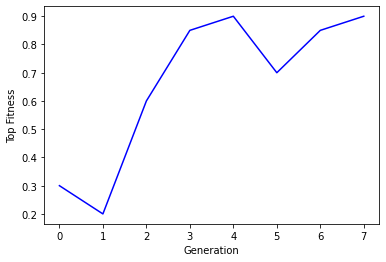

In [224]:
best = generate_ca(popsize = 30,
            generations = 8,
            neighbors = 7,
            n_tests = 20,
            dims = 50,
            perc_zero = .5,
            locality_size = 5,
            elite_prop = .1,
            mut_rate = .5,
            n_mut = 1,
            plot = True)


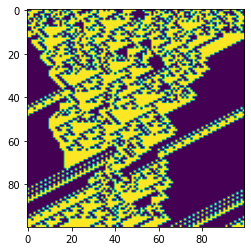

1.0

In [235]:
# print(best)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best, 
        show = True)
fitness(rule = best, 
        n_tests = 10, 
        dims = 100, 
        perc_zero = .5, 
        locality_size = 5)